In [2]:
import pandas as pd
pd.set_option('display.max_rows', 200)

from DataGenerator import DataGenerator

G = DataGenerator(word_count=50000, batch_size=10)

sample_words:               16.29 seconds


['B', 'AE1', 'TH', 'M', 'AH0', 'T', '<STOP>']


/opt/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1: Training Loss: 0.9150 Validation Loss: 0.7933
Epoch 2: Training Loss: 0.8388 Validation Loss: 0.7884
Epoch 3: Training Loss: 0.8367 Validation Loss: 0.7831
Epoch 4: Training Loss: 0.8350 Validation Loss: 0.7934
Epoch 5: Training Loss: 0.8351 Validation Loss: 0.7849
Epoch 6: Training Loss: 0.8361 Validation Loss: 0.7768
Epoch 7: Training Loss: 0.8383 Validation Loss: 0.7894
Epoch 8: Training Loss: 0.8342 Validation Loss: 0.7782
Epoch 9: Training Loss: 0.8353 Validation Loss: 0.7848
Epoch 10: Training Loss: 0.8345 Validation Loss: 0.7764
Epoch 11: Training Loss: 0.8354 Validation Loss: 0.7792
Epoch 12: Training Loss: 0.8340 Validation Loss: 0.7756
Epoch 13: Training Loss: 0.8350 Validation Loss: 0.7775
Epoch 14: Training Loss: 0.8345 Validation Loss: 0.7745
Epoch 15: Training Loss: 0.8370 Validation Loss: 0.7880
Epoch 16: Training Loss: 0.8390 Validation Loss: 0.7786
Epoch 17: Training Loss: 0.8357 Validation Loss: 0.7939
Epoch 18: Training Loss: 0.8353 Validation Loss: 0.7774
E

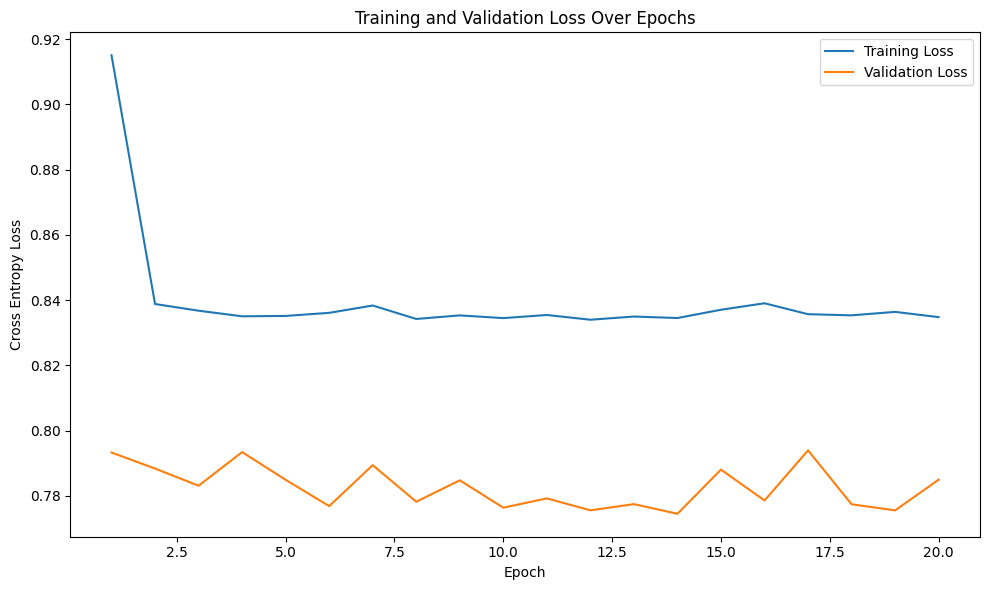

Average Levenshtein distance: 0.0


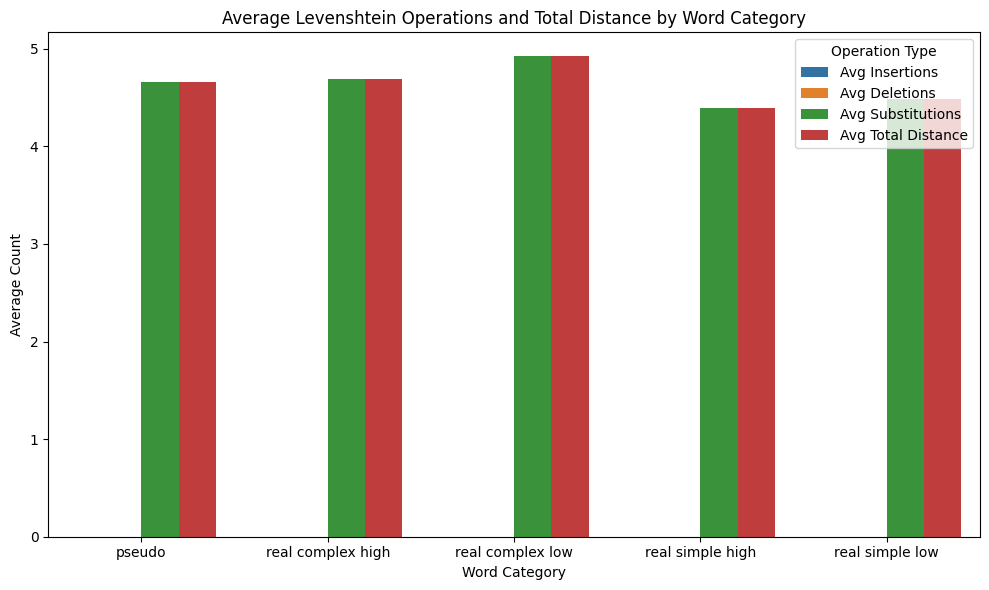

,Word,Length,Frequency,Zipf Frequency,Morph Complexity,Lexicality,Part of Speech,Phonemes,Model_Phonemes,Levenshtein,Insertions,Deletions,Substitutions,Category
0,bathmat,7,low,1.55,complex,real,NOUN,"[B, AE1, TH, M, AH0, T]","[AH0, AH0, T, AH0, AH0, T, <STOP>]",4,0,0,4,real complex low
1,decoder,7,low,2.84,complex,real,NOUN,"[D, IH0, K, OW1, D, ER0]","[T, AH0, AH0, AH0, T, T, <STOP>]",6,0,0,6,real complex low
2,defiant,7,low,3.21,complex,real,ADJ,"[D, IH0, F, AY1, AH0, N, T]","[T, AH0, AH0, AH0, AH0, T, T, <STOP>]",5,0,0,5,real complex low
3,padlock,7,low,2.68,complex,real,NOUN,"[P, AE1, D, L, AA2, K]","[AH0, AH0, T, AH0, AH0, AH0, <STOP>]",6,0,0,6,real complex low
4,immoral,7,low,3.46,complex,real,ADJ,"[IH0, M, AO1, R, AH0, L]","[AH0, AH0, AH0, AH0, AH0, AH0, <STOP>]",5,0,0,5,real complex low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,unrich,6,NaN,NaN,complex,pseudo,NaN,"[AH1, N, R, IH0, CH]","[AH0, T, AH0, AH0, AH0, <STOP>]",5,0,0,5,pseudo
341,upholt,6,NaN,NaN,complex,pseudo,NaN,"[AH0, P, OW1, L, T]","[AH0, AH0, AH0, AH0, T, <STOP>]",3,0,0,3,pseudo
342,warels,6,NaN,NaN,complex,pseudo,NaN,"[W, EH1, R, AH0, L, Z]","[AH0, AH0, AH0, AH0, AH0, T, <STOP>]",5,0,0,5,pseudo
343,wately,6,NaN,NaN,complex,pseudo,NaN,"[W, EY1, T, L, IY0]","[AH0, AH0, T, AH0, T, <STOP>]",4,0,0,4,pseudo


In [4]:
from train_repetition import train_repetition

eval_data = train_repetition(G)

In [5]:
pd.set_option('display.max_rows', 2000)
eval_data

,Word,Length,Frequency,Zipf Frequency,Morph Complexity,Lexicality,Part of Speech,Phonemes,Model_Phonemes,Levenshtein,Insertions,Deletions,Substitutions,Category
0,bathmat,7,low,1.55,complex,real,NOUN,"[B, AE1, TH, M, AH0, T]","[AH0, AH0, T, AH0, AH0, T, <STOP>]",4,0,0,4,real complex low
1,decoder,7,low,2.84,complex,real,NOUN,"[D, IH0, K, OW1, D, ER0]","[T, AH0, AH0, AH0, T, T, <STOP>]",6,0,0,6,real complex low
2,defiant,7,low,3.21,complex,real,ADJ,"[D, IH0, F, AY1, AH0, N, T]","[T, AH0, AH0, AH0, AH0, T, T, <STOP>]",5,0,0,5,real complex low
3,padlock,7,low,2.68,complex,real,NOUN,"[P, AE1, D, L, AA2, K]","[AH0, AH0, T, AH0, AH0, AH0, <STOP>]",6,0,0,6,real complex low
4,immoral,7,low,3.46,complex,real,ADJ,"[IH0, M, AO1, R, AH0, L]","[AH0, AH0, AH0, AH0, AH0, AH0, <STOP>]",5,0,0,5,real complex low
5,nonstop,7,low,3.37,complex,real,ADJ,"[N, AA2, N, S, T, AA1, P]","[T, AH0, T, T, T, AH0, AH0, <STOP>]",6,0,0,6,real complex low
6,parasol,7,low,2.63,complex,real,PROPN,"[P, EH1, R, AH0, S, AO2, L]","[AH0, AH0, AH0, AH0, T, AH0, AH0, <STOP>]",6,0,0,6,real complex low
7,reactor,7,low,3.83,complex,real,NOUN,"[R, IY0, AE1, K, T, ER0]","[AH0, T, AH0, AH0, T, T, <STOP>]",5,0,0,5,real complex low
8,recycle,7,low,3.35,complex,real,NOUN,"[R, IY0, S, AY1, K, AH0, L]","[AH0, T, T, AH0, AH0, AH0, AH0, <STOP>]",6,0,0,6,real complex low
9,reenact,7,low,2.42,complex,real,VERB,"[R, IY0, IH0, N, AE1, K, T]","[AH0, T, AH0, T, AH0, AH0, T, <STOP>]",6,0,0,6,real complex low
